In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib as plt

sns.set_style('white')
sns.set_context('notebook', font_scale=1.3)

import itertools as it
from collections import Counter, defaultdict, deque

import sys
from analysis_utils import *

Error importing rpy2


### First Training Experiment

In [55]:
VERSION = '1A.5'
data = get_data(VERSION, '../experiment/data')
#ids = pd.read_csv(f'../experiment/data/human_raw/{VERSION}/identifiers.csv').set_index('pid')

TRIALS = pd.read_json('../experiment/experiment/static/json/rewards/increasing.json').set_index('trial_id').stateRewards

pdf = data['participants']
mdf = data['mouselab-mdp']

pretest = mdf.query('block == "pre_test"').copy()
training = mdf.query('block == "training"').copy()
posttest = mdf.query('block == "test"').copy()
pretest_and_training = mdf.query('block == "pre_test" or block == "training"').copy()

pretest.trial_index -= pretest.trial_index.min()
pretest.trial_index = pretest.trial_index.astype(int) + 1 
pretest.trial_id = pretest.trial_id.astype(int)

training.trial_index -= training.trial_index.min()
training.trial_index = training.trial_index.astype(int)
training.trial_id = training.trial_id.astype(int)

posttest.trial_index -= posttest.trial_index.min()
posttest.trial_index = posttest.trial_index.astype(int) + 1 
posttest.trial_id = posttest.trial_id.astype(int)

pretest_and_training.trial_index -= pretest_and_training.trial_index.min()
pretest_and_training.trial_index = pretest_and_training.trial_index.astype(int)
pretest_and_training.trial_id = pretest_and_training.trial_id.astype(int)


pdf['total_time'] = data['survey-text'].time_elapsed / 60000

def extract(q):
    return list(map(int, q['click']['state']['target']))

pretest['clicks'] = pretest.queries.apply(extract)
pretest['n_clicks'] = pretest.clicks.apply(len)

training['clicks'] = training.queries.apply(extract)
training['n_clicks'] = training.clicks.apply(len)

posttest['clicks'] = posttest.queries.apply(extract)
posttest['n_clicks'] = posttest.clicks.apply(len)

pretest_and_training['clicks'] = pretest_and_training.queries.apply(extract)
pretest_and_training['n_clicks'] = pretest_and_training.clicks.apply(len)

pdf['n_clicks'] = posttest.groupby('pid').n_clicks.mean()
pdf['score'] = posttest.groupby('pid').score.sum()

ValueError: Expected object or value

In [239]:
len(pdf['pid'])

119

10.05  2.17  4.06
1.34117647059
0.573759792163
13.4328169468
3.49799843228


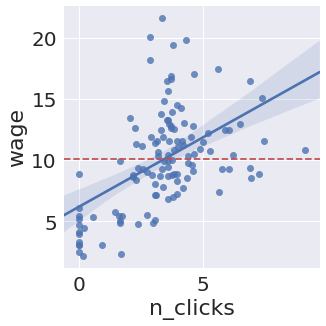

In [245]:
pdf['pay'] = (0.75 + pdf.bonus)
pdf['wage'] = pdf.pay / (pdf.total_time / 60)
print(f'{pdf.wage.mean():.2f}  {pdf.wage.min():.2f}  {pdf.wage.std():.2f}')

sns.lmplot('n_clicks', 'wage', data=pdf)
plt.axhline(pdf.wage.mean(), c='r', ls='--')

print(pdf.bonus.mean())
print(pdf.bonus.std())

print(pdf.total_time.mean())
print(pdf.total_time.std())

In [240]:
feedback_group  = pdf.query("with_feedback == True")
control_group = pdf.query("with_feedback == False")

n_feedback = len(feedback_group.pid)
n_control =  len(control_group.pid)
print('n_feedback: {}'.format(n_feedback))
print('n_control: {}'.format(n_control))

avg_score_training=posttest[posttest['pid'].isin(feedback_group.pid)].score.mean()
avg_score_control=posttest[posttest['pid'].isin(control_group.pid)].score.mean()

N_feedback = len(posttest[posttest['pid'].isin(feedback_group.pid)].score)
N_control = len(posttest[posttest['pid'].isin(control_group.pid)].score)

#t-test!!
t,p = stats.ttest_ind(posttest[posttest['pid'].isin(feedback_group.pid)].score,posttest[posttest['pid'].isin(control_group.pid)].score)

print("Participants who received feedback performed significantly better in the posttest than participants who didn't ({:3.1f} vs. {:3.1f}, t({})={:3.1f}, p={:4.4f}).".
      format(avg_score_training,avg_score_control,N_feedback+N_control-2,t,p))

#print(posttest[posttest['pid'].isin(feedback_group.pid)].score.std()/np.sqrt(n_feedback * 20))
#print(posttest[posttest['pid'].isin(control_group.pid)].score.std()/np.sqrt(n_control * 20))

n_feedback: 56
n_control: 57
Participants who received feedback performed significantly better in the posttest than participants who didn't (36.2 vs. 24.6, t(2258)=10.7, p=0.0000).


Text(0.5,1,'Performance in the Post Test')

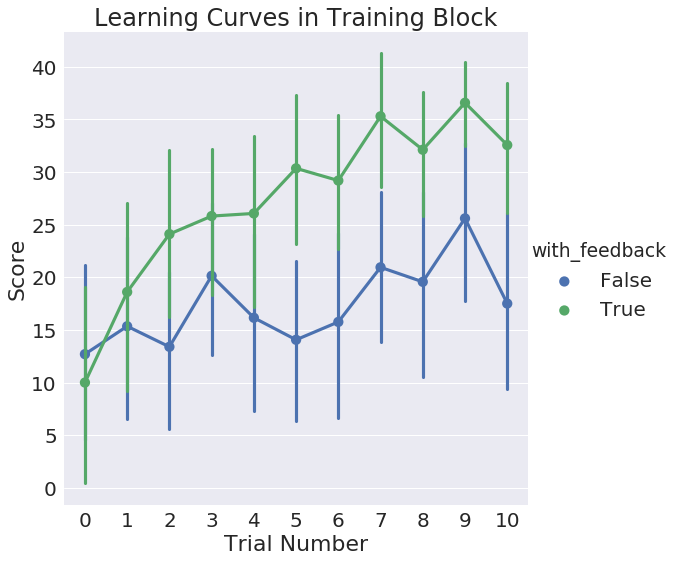

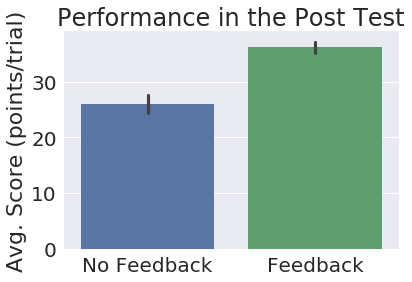

In [234]:
#print(pretest.score.mean())
#print(posttest.score.mean())

pretest["with_feedback"]=pd.Series(pretest['pid'].isin(feedback_group.pid))
training["with_feedback"]=pd.Series(training['pid'].isin(feedback_group.pid))
posttest["with_feedback"]=pd.Series(posttest['pid'].isin(feedback_group.pid))
pretest_and_training["with_feedback"]=pd.Series(pretest_and_training['pid'].isin(feedback_group.pid))

sns.set(font_scale=2)
sns.factorplot(x='trial_index', y='score', hue='with_feedback', data=pretest_and_training, size=8)
plt.xlabel('Trial Number')
plt.title('Learning Curves in Training Block')
plt.ylabel('Score')

matplotlib.rcParams.update({'font.size': 22})

plt.figure()
sns.barplot(y='score', x='with_feedback',data=posttest)
plt.xlabel('')
plt.xticks([0,1],['No Feedback','Feedback'])
plt.ylabel('Avg. Score (points/trial)')
plt.title('Performance in the Post Test')

#print(n_feedback)
#print(n_control)

In [235]:
import statsmodels.formula.api as smf

model = smf.ols('score ~ trial_index * with_feedback', data=pretest_and_training).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     22.31
Date:                Thu, 01 Mar 2018   Prob (F-statistic):           4.34e-14
Time:                        14:05:31   Log-Likelihood:                -6343.2
No. Observations:                1309   AIC:                         1.269e+04
Df Residuals:                    1305   BIC:                         1.272e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                            13.5274      2.191      6.174      0.000       9.229      17.825
with_feedback[T.True]                 3.3167      3.194      1.039      0.299      -2.949       9.582
trial_index                           0.7710      0.370      2.082      0.038       0.044       1.497
trial_index:with_feedback[T.True]     1.3284      0.540      2.461      0.014       0.269       2.387
==============================================================================
Omnibus:                      183.224   Durbin-Watson:                   1.635
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              264.720
Skew:                          -1.091   Prob(JB):                     3.29e-58
Kurtosis:                       3.304   Cond. No.                         28.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [220]:
pids = pdf.pid
improvement = np.array([])
received_FB = np.array([])
for p in pids:
    improvement = np.append(improvement,[pretest_and_training.query("trial_index==10 and pid == {}".format(p)).score.mean() - pretest_and_training.query("trial_index==0 and pid == {}".format(p)).score.mean()]) 
    received_FB = np.append(received_FB, [p in feedback_group.pid])   

avg_improvement_with_FB = np.mean(improvement[received_FB==True])
avg_improvement_without_FB = np.mean(improvement[received_FB==False])

t,p = stats.ttest_ind(improvement[received_FB==True],improvement[received_FB==False])
df = n_feedback+n_control-2
print("Participants in the feedback condition improved significantly more during the training block than participants in the control condition (+{:4.3} vs. +{:4.3}  t({})={:4.3}, p={:4.3}).".format(avg_improvement_with_FB,avg_improvement_without_FB,df,t,p))

Participants in the feedback condition improved significantly more during the training block than participants in the control condition (+22.6 vs. +4.81  t(111)=2.22, p=0.0281).


## Analyze the effect of training on post-test strategy

In [34]:
import statsmodels.stats.proportion as proportion

trial_ids = posttest['clicks'].keys()

level_of_first_click = np.array([])
nr_clicks = np.array([])

nodes_by_level = dict()
nodes_by_level[0]=[0]
nodes_by_level[1]=[1,5,9]
nodes_by_level[2]=[2,6,10]
nodes_by_level[3]=[3,4,7,8,11,12]

for t in trial_ids:
    clicks = posttest['clicks'][t]
    
    nr_clicks = np.append(nr_clicks,[len(clicks)])
    
    if len(clicks)>0:    
        first_click = clicks[0]
        for l in range(len(nodes_by_level)):
            if first_click in nodes_by_level[l]:
                level_of_first_click = np.append(level_of_first_click,[l])
    else:
            level_of_first_click = np.append(level_of_first_click,[0])

posttest['level_of_first_click'] = pd.Series(level_of_first_click)
            
np.mean(level_of_first_click[posttest.with_feedback]==3)
np.mean(level_of_first_click[posttest.with_feedback==False]==3)

plt.figure()
sns.distplot(level_of_first_click[posttest.with_feedback==True], color='green', kde=False, rug=True,label='with feedback');
sns.distplot(level_of_first_click[posttest.with_feedback==False], color='red', kde=False, rug=True,label='no feedback');
plt.legend()
plt.xlabel('Level of the first click (0: no click, 3: leaf node)')

click_levels = [0,1,2,3]
z = dict()
p = dict()

nr_observations_by_level_FB = np.array(click_levels)
nr_observations_by_level_noFB = np.array(click_levels)

for l in click_levels:
    counts= np.array([ np.sum(level_of_first_click[posttest.with_feedback==True]==l),
             np.sum(level_of_first_click[posttest.with_feedback==False]==l)])
    
    nobs = np.array([ len(level_of_first_click[posttest.with_feedback==True]),
             len(level_of_first_click[posttest.with_feedback==False])])
    
    nr_observations_by_level_FB[l] = counts[0]
    nr_observations_by_level_noFB[l] = counts[1]

    
    z[l],p[l] = proportion.proportions_ztest(counts, nobs)

    print('{:5.2}% vs. {:5.2}% (Z={:4.3}, p={:4.3})'.format(100*counts[0]/nobs[0], 100*counts[1]/nobs[1], z[l],p[l]))

plt.figure()
sns.barplot(x='with_feedback',y='n_clicks',data=posttest)

avg_nr_clicks_FB=posttest[posttest['pid'].isin(feedback_group.pid)].n_clicks.mean()
avg_nr_clicks_noFB=posttest[posttest['pid'].isin(control_group.pid)].n_clicks.mean()

std_nr_clicks_FB=posttest[posttest['pid'].isin(feedback_group.pid)].n_clicks.std()
std_nr_clicks_noFB=posttest[posttest['pid'].isin(control_group.pid)].n_clicks.std()


t,p = stats.ttest_ind(posttest[posttest['pid'].isin(feedback_group.pid)].n_clicks,posttest[posttest['pid'].isin(control_group.pid)].n_clicks)
print("{:3.2} +- {:3.2} vs. {:3.2} +- {:3.2} (t({})={:3.2}, p={:5.4})".format(
        avg_nr_clicks_FB,avg_nr_clicks_noFB,std_nr_clicks_FB,std_nr_clicks_noFB,
        N_feedback+N_control-2, t, p))

IndexError: boolean index did not match indexed array along dimension 0; dimension is 1214 but corresponding boolean dimension is 2360

1
0.921% vs.  20.1% (Z=-14.5, p=1.51e-47)
2
 0.46% vs.  1.25% (Z=-1.96, p=0.0496)
3
 98.6% vs.  78.6% (Z=14.6, p=5.5e-48)


Text(0,0.5,'Frequency of First Click')

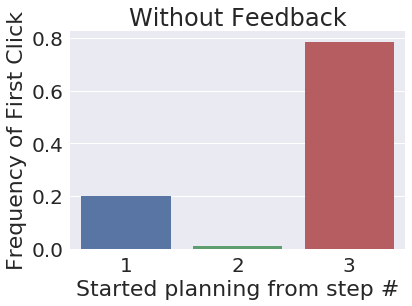

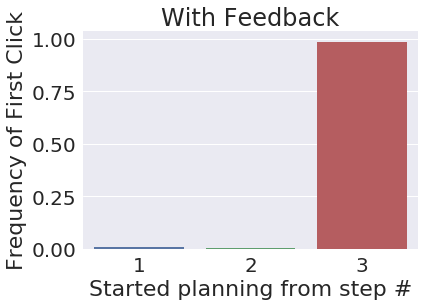

In [223]:
#todo: test if FB increased the frequency of backward planning beyond reducing the frequency of no planning

click_levels = [1,2,3]

rel_freq_FB = np.array([0.0,0.0,0.0])
rel_freq_no_FB = np.array([0.0,0.0,0.0])

z = dict()
p = dict()

for l in click_levels:  
    print(l)
    rel_freq_FB[l-1] = float(nr_observations_by_level_FB[l])/float(np.sum(nr_observations_by_level_FB[1:]))
    rel_freq_no_FB[l-1] = float(nr_observations_by_level_noFB[l])/float(np.sum(nr_observations_by_level_noFB[1:]))
    counts = [nr_observations_by_level_FB[l], nr_observations_by_level_noFB[l]]
    nobs = [np.sum(nr_observations_by_level_FB[1:]),np.sum(nr_observations_by_level_noFB[1:])]
    z[l],p[l] = proportion.proportions_ztest(counts, nobs)
    print('{:5.3}% vs. {:5.3}% (Z={:4.3}, p={:4.3})'.format(100*counts[0]/nobs[0], 100*counts[1]/nobs[1], z[l],p[l]))

                                                          

sns.barplot(x=[1,2,3],y=rel_freq_no_FB,label='no feedback')
plt.xlabel('Started planning from step #')
plt.title('Without Feedback')
plt.ylabel('Frequency of First Click')

plt.figure()
sns.barplot(x=[1,2,3],y=rel_freq_FB,label='feedback')    
#plt.legend()
plt.xlabel('Started planning from step #')
plt.title('With Feedback')
plt.ylabel('Frequency of First Click')



## Near-Transfer Experiment

In [56]:
VERSION = 'T1.1'
data = get_data(VERSION, '../near_transfer/data')
#ids = pd.read_csv(f'../experiment/data/human_raw/{VERSION}/identifiers.csv').set_index('pid')

TRAINING_TRIALS = pd.read_json('../near_transfer/experiment/static/json/mcrl_trials/increasing.json').set_index('trial_id').stateRewards
TEST_TRIALS = pd.read_json('../near_transfer/experiment/static/json/rewards/31123_increasing1.json').set_index('trial_id').stateRewards

pdf = data['participants']
mdf = data['mouselab-mdp']

pretest = mdf.query('block == "pre_test"').copy()
training = mdf.query('block == "training"').copy()
posttest = mdf.query('block == "test"').copy()
pretest_and_training = mdf.query('block == "pre_test" or block == "training"').copy()

pretest.trial_index -= pretest.trial_index.min()
pretest.trial_index = pretest.trial_index.astype(int) + 1 
pretest.trial_id = pretest.trial_id.astype(int)

training.trial_index -= training.trial_index.min()
training.trial_index = training.trial_index.astype(int)
training.trial_id = training.trial_id.astype(int)

posttest.trial_index -= posttest.trial_index.min()
posttest.trial_index = posttest.trial_index.astype(int) + 1 
posttest.trial_id = posttest.trial_id.astype(int)

pretest_and_training.trial_index -= pretest_and_training.trial_index.min()
pretest_and_training.trial_index = pretest_and_training.trial_index.astype(int)
pretest_and_training.trial_id = pretest_and_training.trial_id.astype(int)


pdf['total_time'] = data['survey-text'].time_elapsed / 60000

def extract(q):
    return list(map(int, q['click']['state']['target']))

pretest['clicks'] = pretest.queries.apply(extract)
pretest['n_clicks'] = pretest.clicks.apply(len)

training['clicks'] = training.queries.apply(extract)
training['n_clicks'] = training.clicks.apply(len)

posttest['clicks'] = posttest.queries.apply(extract)
posttest['n_clicks'] = posttest.clicks.apply(len)

pretest_and_training['clicks'] = pretest_and_training.queries.apply(extract)
pretest_and_training['n_clicks'] = pretest_and_training.clicks.apply(len)

pdf['n_clicks'] = posttest.groupby('pid').n_clicks.mean()
pdf['score'] = posttest.groupby('pid').score.sum()

nr_participants = len(pdf['pid'])

Average wage: 9.44, Minimum wage:  1.56, STD of wage:  3.74
Average bonus: $1.499 +/- $0.587
Average duration: 16.3 +/-  5.7 minutes


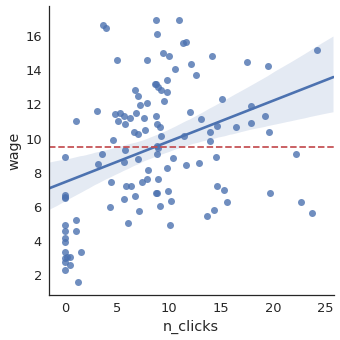

In [57]:
pdf['pay'] = (0.8 + pdf.bonus)
pdf['wage'] = pdf.pay / (pdf.total_time / 60)

print(f'Average wage: {pdf.wage.mean():.2f}, Minimum wage:  {pdf.wage.min():.2f}, STD of wage:  {pdf.wage.std():.2f}')

sns.lmplot('n_clicks', 'wage', data=pdf)
plt.axhline(pdf.wage.mean(), c='r', ls='--')

print("Average bonus: ${:5.4} +/- ${:4.3}".format(pdf.bonus.mean(),pdf.bonus.std()))

print("Average duration: {:4.3} +/- {:4.3} minutes".format(pdf.total_time.mean(),pdf.total_time.std()))

In [58]:
feedback_group  = pdf.query("with_feedback == True")
control_group = pdf.query("with_feedback == False")

n_feedback = len(feedback_group.pid)
n_control =  len(control_group.pid)
print('n_feedback: {}'.format(n_feedback))
print('n_control: {}'.format(n_control))

avg_score_training=posttest[posttest['pid'].isin(feedback_group.pid)].score.mean()
avg_score_control=posttest[posttest['pid'].isin(control_group.pid)].score.mean()

N_feedback = len(posttest[posttest['pid'].isin(feedback_group.pid)].score)
N_control = len(posttest[posttest['pid'].isin(control_group.pid)].score)

#t-test!!
t,p = stats.ttest_ind(posttest[posttest['pid'].isin(feedback_group.pid)].score,posttest[posttest['pid'].isin(control_group.pid)].score)

print("Participants who received feedback in the training block performed significantly better in the transfer task than participants who didn't ({:3.1f} $/trial vs. {:3.1f} $/trial, t({})={:3.1f}, p={:4.4f}).".
      format(avg_score_training,avg_score_control,N_feedback+N_control-2,t,p))

#print(posttest[posttest['pid'].isin(feedback_group.pid)].score.std()/np.sqrt(n_feedback * 20))
#print(posttest[posttest['pid'].isin(control_group.pid)].score.std()/np.sqrt(n_control * 20))

n_feedback: 59
n_control: 59
Participants who received feedback in the training block performed significantly better in the transfer task than participants who didn't (37.4 $/trial vs. 27.4 $/trial, t(2358)=8.8, p=0.0000).


Text(0.5,1,'Performance on the Transfer Task')

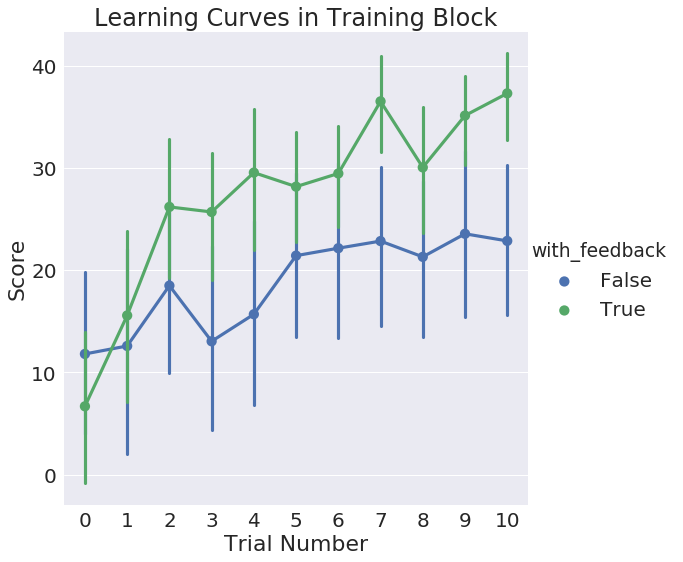

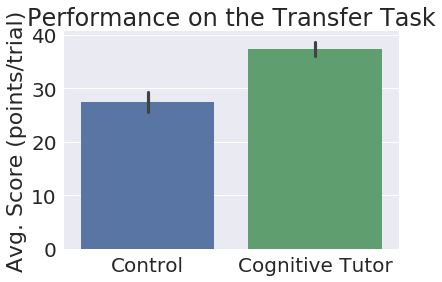

In [59]:
#print(pretest.score.mean())
#print(posttest.score.mean())

pretest["with_feedback"]=pd.Series(pretest['pid'].isin(feedback_group.pid))
training["with_feedback"]=pd.Series(training['pid'].isin(feedback_group.pid))
posttest["with_feedback"]=pd.Series(posttest['pid'].isin(feedback_group.pid))
pretest_and_training["with_feedback"]=pd.Series(pretest_and_training['pid'].isin(feedback_group.pid))

sns.set(font_scale=2)
sns.factorplot(x='trial_index', y='score', hue='with_feedback', data=pretest_and_training, size=8)
plt.xlabel('Trial Number')
plt.title('Learning Curves in Training Block')
plt.ylabel('Score')

matplotlib.rcParams.update({'font.size': 22})

plt.figure()
sns.barplot(y='score', x='with_feedback',data=posttest)
plt.xlabel('')
plt.xticks([0,1],['Control','Cognitive Tutor'])
plt.ylabel('Avg. Score (points/trial)')
plt.title('Performance on the Transfer Task')

#print(n_feedback)
#print(n_control)

In [60]:
import statsmodels.formula.api as smf

model = smf.ols('score ~ trial_index * with_feedback', data=pretest_and_training).fit()
model.summary()

#1.2146+1.1878

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.061
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     28.16
Date:                Wed, 07 Mar 2018   Prob (F-statistic):           1.22e-17
Time:                        08:23:22   Log-Likelihood:                -6209.9
No. Observations:                1298   AIC:                         1.243e+04
Df Residuals:                    1294   BIC:                         1.245e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                            12.6356      2.129      5.936      0.000       8.460      16.811
with_feedback[T.True]                 2.6510      3.010      0.881      0.379      -3.255       8.557
trial_index                           1.2146      0.360      3.376      0.001       0.509       1.920
trial_index:with_feedback[T.True]     1.1878      0.509      2.334      0.020       0.190       2.186
==============================================================================
Omnibus:                      186.023   Durbin-Watson:                   1.563
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              268.831
Skew:                          -1.081   Prob(JB):                     4.21e-59
Kurtosis:                       3.545   Cond. No.                         29.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [61]:
pids = pdf.pid
improvement = np.array([])
received_FB = np.array([])
for p in pids:
    improvement = np.append(improvement,[pretest_and_training.query("trial_index==10 and pid == {}".format(p)).score.mean() - pretest_and_training.query("trial_index==1 and pid == {}".format(p)).score.mean()]) 
    received_FB = np.append(received_FB, [p in feedback_group.pid])   

avg_improvement_with_FB = np.mean(improvement[received_FB==True])
avg_improvement_without_FB = np.mean(improvement[received_FB==False])

t,p = stats.ttest_ind(improvement[received_FB==True],improvement[received_FB==False])
df = n_feedback+n_control-2
print("Participants in the feedback condition improved significantly more during the training block than participants in the control condition (+{:4.3} vs. +{:4.3}  t({})={:4.3}, p={:4.3}).".format(avg_improvement_with_FB,avg_improvement_without_FB,df,t,p))

Participants in the feedback condition improved significantly more during the training block than participants in the control condition (+21.7 vs. +10.3  t(116)= 1.4, p=0.165).


Participants in the feedback condition improved significantly more on the transfer task than participants in the control condition (+30.7 vs. +15.6,  t(116)=2.53, p=0.0127).


Text(67.5773,0.5,'Score')

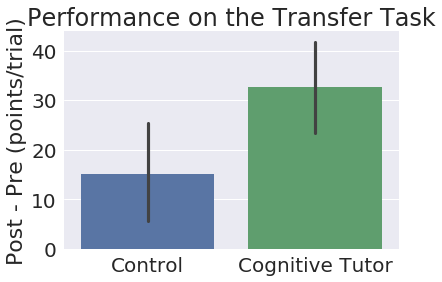

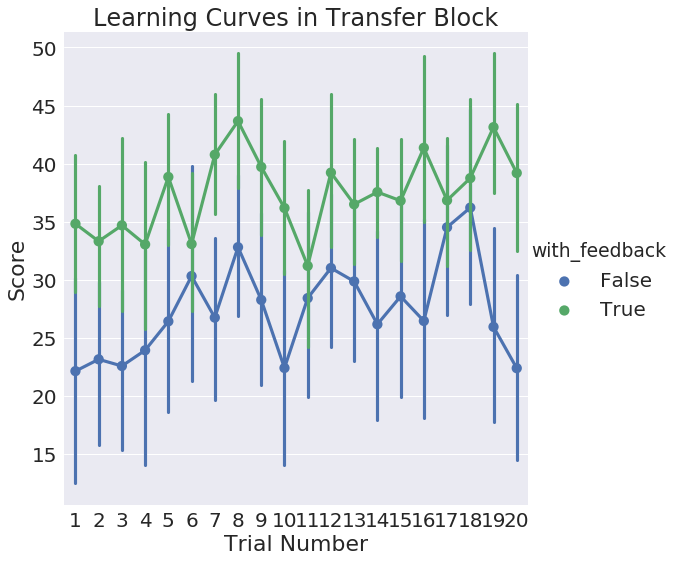

In [63]:
pids = pdf.pid
improvement = np.array([])
received_FB = np.array([])
for p in pids:
    improvement = np.append(improvement,[posttest.query("pid == {}".format(p)).score.mean() - pretest.query("pid == {}".format(p)).score.mean()]) 
    received_FB = np.append(received_FB, [p in feedback_group.pid])   

posttest['improvement']=pd.Series(improvement)
posttest['received_FB']=pd.Series(received_FB)
    
avg_improvement_with_FB = np.mean(improvement[received_FB==True])
avg_improvement_without_FB = np.mean(improvement[received_FB==False])

t,p = stats.ttest_ind(improvement[received_FB==True],improvement[received_FB==False])
df = n_feedback+n_control-2
print("Participants in the feedback condition improved significantly more on the transfer task than participants in the control condition (+{:4.3} vs. +{:4.3},  t({})={:4.3}, p={:4.3}).".format(avg_improvement_with_FB,avg_improvement_without_FB,df,t,p))

matplotlib.rcParams.update({'font.size': 22})

plt.figure()
sns.barplot(y='improvement', x='received_FB',data=posttest,ci=95,n_boot=1000)
plt.xlabel('')
plt.xticks([0,1],['Control','Cognitive Tutor'])
plt.ylabel('Post - Pre (points/trial)')
plt.title('Performance on the Transfer Task')


sns.set(font_scale=2)
sns.factorplot(x='trial_index', y='score', hue='with_feedback', data=posttest, size=8)
plt.xlabel('Trial Number')
plt.title('Learning Curves in Transfer Block')
plt.ylabel('Score')

Text(0,0.5,'Relative Frequency')

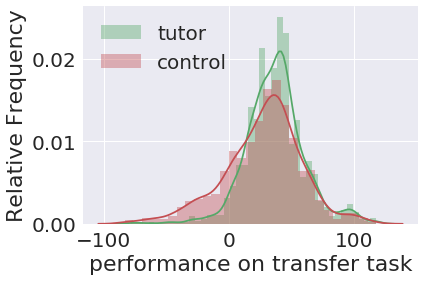

In [51]:
plt.figure()
sns.distplot(posttest[posttest.with_feedback].score,color='g',label='tutor')
sns.distplot(posttest[posttest.with_feedback==False].score,color='r',label='control')
plt.legend(loc='upper left')
plt.xlabel('performance on transfer task')
plt.ylabel('Relative Frequency')

level 0:   3.1% vs. 2.7e+01% (Z=-16.1, p=2.49e-58)
level 1:   1.4% vs.   7.9% (Z=-7.42, p=1.16e-13)
level 2:  0.34% vs.  0.17% (Z=0.818, p=0.414)
level 3:   2.8% vs.   1.4% (Z=2.29, p=0.0222)
level 4:  0.93% vs.   1.7% (Z=-1.63, p=0.104)
level 5: 9.1e+01% vs. 6.2e+01% (Z=16.8, p=1.47e-63)
Avg. nr. clicks: 9.5 +- 7.5 vs. 6.9 +- 7.8 (t(2358)=6.6, p=4.538e-11)


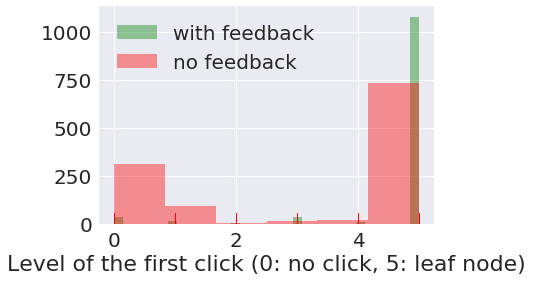

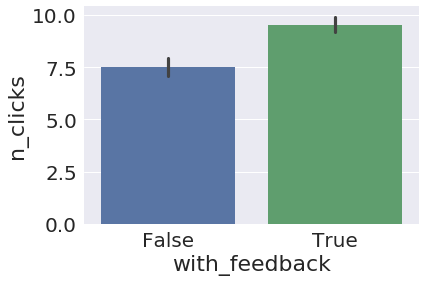

In [35]:
import statsmodels.stats.proportion as proportion

trial_ids = posttest['clicks'].keys()

level_of_first_click = np.array([])
nr_clicks = np.array([])

#3-1-1-2-3 environment
nodes_by_level = dict()
nodes_by_level[0]=[0]
nodes_by_level[1]=[1,12,23]
nodes_by_level[2]=[2,13,24]
nodes_by_level[3]=[3,14,25]
nodes_by_level[4]=[4,8,15,19,26,30]
nodes_by_level[5]=[5,6,7,9,10,11,16,17,18,20,21,22,27,28,29,31,32,33]

for t in trial_ids:
    clicks = posttest['clicks'][t]
    
    nr_clicks = np.append(nr_clicks,[len(clicks)])
    
    if len(clicks)>0:    
        first_click = clicks[0]
        for l in range(len(nodes_by_level)):
            if first_click in nodes_by_level[l]:
                level_of_first_click = np.append(level_of_first_click,[l])
    else:
            level_of_first_click = np.append(level_of_first_click,[0])

posttest['level_of_first_click'] = pd.Series(level_of_first_click)
            
np.mean(level_of_first_click[posttest.with_feedback==True]==3)
np.mean(level_of_first_click[posttest.with_feedback==False]==3)

plt.figure()
sns.distplot(level_of_first_click[posttest.with_feedback==True], color='green', kde=False, rug=True,label='with feedback');
sns.distplot(level_of_first_click[posttest.with_feedback==False], color='red', kde=False, rug=True,label='no feedback');
plt.legend()
plt.xlabel('Level of the first click (0: no click, 5: leaf node)')

click_levels = [0,1,2,3,4,5]
leaf_level = 5;
z = dict()
p = dict()

nr_observations_by_level_FB = np.array(click_levels)
nr_observations_by_level_noFB = np.array(click_levels)

for l in click_levels:
    counts= np.array([ np.sum(level_of_first_click[posttest.with_feedback==True]==l),
             np.sum(level_of_first_click[posttest.with_feedback==False]==l)])
    
    nobs = np.array([ len(level_of_first_click[posttest.with_feedback==True]),
             len(level_of_first_click[posttest.with_feedback==False])])
    
    nr_observations_by_level_FB[l] = counts[0]
    nr_observations_by_level_noFB[l] = counts[1]

    
    z[l],p[l] = proportion.proportions_ztest(counts, nobs)

    print('level {}: {:5.2}% vs. {:5.2}% (Z={:4.3}, p={:4.3})'.format(l,100*counts[0]/nobs[0], 100*counts[1]/nobs[1], z[l],p[l]))

plt.figure()
sns.barplot(x='with_feedback',y='n_clicks',data=posttest)

avg_nr_clicks_FB=posttest[posttest['pid'].isin(feedback_group.pid)].n_clicks.mean()
avg_nr_clicks_noFB=posttest[posttest['pid'].isin(control_group.pid)].n_clicks.mean()

std_nr_clicks_FB=posttest[posttest['pid'].isin(feedback_group.pid)].n_clicks.std()
std_nr_clicks_noFB=posttest[posttest['pid'].isin(control_group.pid)].n_clicks.std()


t,p = stats.ttest_ind(posttest[posttest['pid'].isin(feedback_group.pid)].n_clicks,posttest[posttest['pid'].isin(control_group.pid)].n_clicks)
print("Avg. nr. clicks: {:3.2} +- {:3.2} vs. {:3.2} +- {:3.2} (t({})={:3.2}, p={:5.4})".format(
        avg_nr_clicks_FB,avg_nr_clicks_noFB,std_nr_clicks_FB,std_nr_clicks_noFB,
        N_feedback+N_control-2, t, p))

1
 2.21% vs.  14.8% (Z=-6.33, p=2.41e-10)
2
 0.98% vs. 0.302% (Z=1.12, p=0.263)
3
 4.41% vs.  1.51% (Z=2.26, p=0.0239)
4
 0.98% vs. 0.302% (Z=1.12, p=0.263)
5
 91.4% vs.  83.1% (Z=3.43, p=0.000601)


Text(0,0.5,'Frequency of First Click')

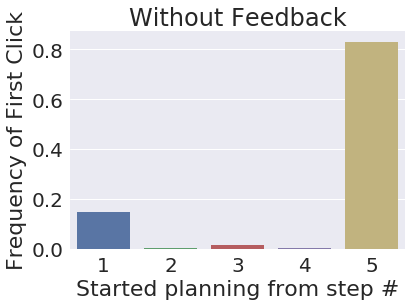

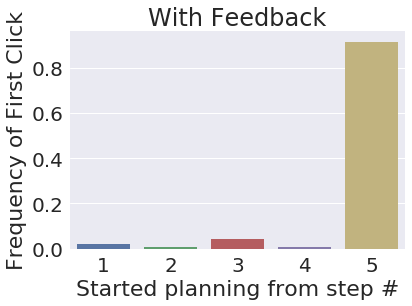

In [77]:
#todo: test if FB increased the frequency of backward planning beyond reducing the frequency of no planning

click_levels = [1,2,3,4,5]

rel_freq_FB = np.array([0.0,0.0,0.0,0.0,0.0])
rel_freq_no_FB = np.array([0.0,0.0,0.0,0.0,0.0])

z = dict()
p = dict()

for l in click_levels:  
    print(l)
    rel_freq_FB[l-1] = float(nr_observations_by_level_FB[l])/float(np.sum(nr_observations_by_level_FB[1:]))
    rel_freq_no_FB[l-1] = float(nr_observations_by_level_noFB[l])/float(np.sum(nr_observations_by_level_noFB[1:]))
    counts = [nr_observations_by_level_FB[l], nr_observations_by_level_noFB[l]]
    nobs = [np.sum(nr_observations_by_level_FB[1:]),np.sum(nr_observations_by_level_noFB[1:])]
    z[l],p[l] = proportion.proportions_ztest(counts, nobs)
    print('{:5.3}% vs. {:5.3}% (Z={:4.3}, p={:4.3})'.format(100*counts[0]/nobs[0], 100*counts[1]/nobs[1], z[l],p[l]))

                                                          
sns.barplot(x=[1,2,3,4,5],y=rel_freq_no_FB,label='no feedback')
plt.xlabel('Started planning from step #')
plt.title('Without Feedback')
plt.ylabel('Frequency of First Click')

plt.figure()
sns.barplot(x=[1,2,3,4,5],y=rel_freq_FB,label='feedback')    
#plt.legend()
plt.xlabel('Started planning from step #')
plt.title('With Feedback')
plt.ylabel('Frequency of First Click')

# Retention Experiment

In [60]:
VERSION = 'R0.9'
data = get_data(VERSION, '../retention/data')
#ids = pd.read_csv(f'../experiment/data/human_raw/{VERSION}/identifiers.csv').set_index('pid')

TRAINING_TRIALS = pd.read_json('../retention/experiment/static/json/mcrl_trials/increasing.json').set_index('trial_id').stateRewards
TEST_TRIALS = pd.read_json('../retention/experiment/static/json/rewards/31123_increasing1.json').set_index('trial_id').stateRewards

pdf = data['participants']
mdf = data['mouselab-mdp']

pretest = mdf.query('block == "pre_test"').copy()
training = mdf.query('block == "training"').copy()
posttest = mdf.query('block == "test"').copy()
pretest_and_training = mdf.query('block == "pre_test" or block == "training"').copy()

pretest.trial_index -= pretest.trial_index.min()
pretest.trial_index = pretest.trial_index.astype(int) + 1 
pretest.trial_id = pretest.trial_id.astype(int)

training.trial_index -= training.trial_index.min()
training.trial_index = training.trial_index.astype(int)
training.trial_id = training.trial_id.astype(int)

posttest.trial_index -= posttest.trial_index.min()
posttest.trial_index = posttest.trial_index.astype(int) + 1 
posttest.trial_id = posttest.trial_id.astype(int)

pretest_and_training.trial_index -= pretest_and_training.trial_index.min()
pretest_and_training.trial_index = pretest_and_training.trial_index.astype(int)
pretest_and_training.trial_id = pretest_and_training.trial_id.astype(int)


pdf['total_time'] = data['survey-text'].time_elapsed / 60000

def extract(q):
    return list(map(int, q['click']['state']['target']))

pretest['clicks'] = pretest.queries.apply(extract)
pretest['n_clicks'] = pretest.clicks.apply(len)

training['clicks'] = training.queries.apply(extract)
training['n_clicks'] = training.clicks.apply(len)

posttest['clicks'] = posttest.queries.apply(extract)
posttest['n_clicks'] = posttest.clicks.apply(len)

pretest_and_training['clicks'] = pretest_and_training.queries.apply(extract)
pretest_and_training['n_clicks'] = pretest_and_training.clicks.apply(len)

pdf['n_clicks'] = posttest.groupby('pid').n_clicks.mean()
pdf['score'] = posttest.groupby('pid').score.sum()

stage = []
start_times = pdf['startTime']
for t in start_times:
    if t[0:3]=='Wed' or t[0:3]=="Fri":
        stage.append(1)
    else:
        stage.append(2)

pdf['stage']=pd.Series(days)

experimental_group = set(pdf.query('with_feedback == True and stage==1' ).pid)
control_group = set(pdf.query('with_feedback == False and stage==1').pid)

posttest['with_feedback']=pd.Series(posttest['pid'].isin(experimental_group))

nr_participants = len(pdf['pid'])

Average wage: 16.33, Minimum wage:  0.98, STD of wage:  12.57
Average bonus: $2.171 +/- $1.85
Average duration: 7.73 +/- 3.13 minutes


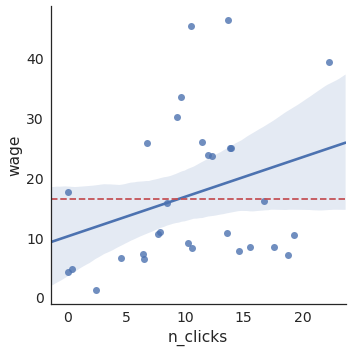

In [20]:
pdf['pay'] = pdf.bonus+0.1
pdf['wage'] = pdf.pay / (pdf.total_time / 60)

print(f'Average wage: {pdf.wage.mean():.2f}, Minimum wage:  {pdf.wage.min():.2f}, STD of wage:  {pdf.wage.std():.2f}')

sns.lmplot('n_clicks', 'wage', data=pdf)
plt.axhline(pdf.wage.mean(), c='r', ls='--')

print("Average bonus: ${:5.4} +/- ${:4.3}".format(pdf.bonus.mean(),pdf.bonus.std()))

print("Average duration: {:4.3} +/- {:4.3} minutes".format(pdf.total_time.mean(),pdf.total_time.std()))

In [59]:
n_feedback = len(set(posttest[posttest['pid'].isin(experimental_group)].pid))
n_control =  len(set(posttest[posttest['pid'].isin(control_group)].pid))
print('n_feedback: {}'.format(n_feedback))
print('n_control: {}'.format(n_control))

avg_score_training=posttest[posttest['pid'].isin(experimental_group)].score.mean()
avg_score_control=posttest[posttest['pid'].isin(control_group)].score.mean()

N_feedback = len(posttest[posttest['pid'].isin(experimental_group)].score)
N_control = len(posttest[posttest['pid'].isin(control_group)].score)

#t-test!!
t,p = stats.ttest_ind(posttest[posttest['pid'].isin(experimental_group)].score,posttest[posttest['pid'].isin(control_group)].score)

print("After about 24h, participants who had received feedback in the training block still performed significantly better on the transfer task than participants who had practiced without feedback ({:3.1f} $/trial vs. {:3.1f} $/trial, t({})={:3.1f}, p={:4.4f}).".
      format(avg_score_training,avg_score_control,N_feedback+N_control-2,t,p))

#print(posttest[posttest['pid'].isin(feedback_group.pid)].score.std()/np.sqrt(n_feedback * 20))
#print(posttest[posttest['pid'].isin(control_group.pid)].score.std()/np.sqrt(n_control * 20))

n_feedback: 21
n_control: 20
After about 24h, participants who had received feedback in the training block still performed significantly better in the transfer task than participants who had practiced without feedback (41.3 $/trial vs. 30.1 $/trial, t(818)=5.8, p=0.0000).


Text(0.5,1,'Performance on the Transfer Task after 24 hours')

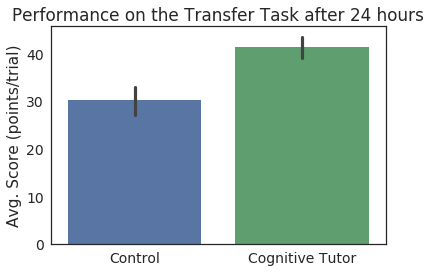

In [62]:
plt.figure()
sns.barplot(y='score', x='with_feedback',data=posttest)
plt.xlabel('')
plt.xticks([0,1],['Control','Cognitive Tutor'])
plt.ylabel('Avg. Score (points/trial)')
plt.title('Performance on the Transfer Task after 24 hours')

Participants in the feedback condition improved significantly more on the transfer task than participants in the control condition (+32.9 vs. +23.4,  t(39)=1.16, p=0.248).


Text(0.5,1,'Improvement on the Transfer Task after 24h')

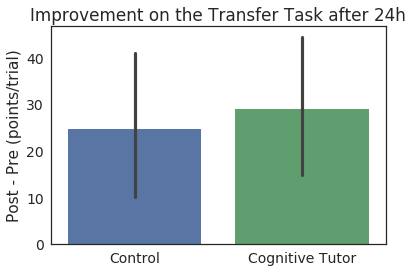

In [72]:
pids = pdf.pid
improvement = np.array([])
received_FB = np.array([])
for p in pids:
    improvement = np.append(improvement,[posttest.query("pid == {}".format(p)).score.mean() - pretest.query("pid == {}".format(p)).score.mean()]) 
    received_FB = np.append(received_FB, [p in feedback_group.pid])   

posttest['improvement']=pd.Series(improvement)
posttest['received_FB']=pd.Series(received_FB)
    
avg_improvement_with_FB = np.nanmean(improvement[received_FB==True])
avg_improvement_without_FB = np.nanmean(improvement[received_FB==False])

t,p = stats.ttest_ind(improvement[received_FB==True],improvement[received_FB==False],nan_policy='omit')
df = n_feedback+n_control-2
print("Participants in the feedback condition improved significantly more on the transfer task than participants in the control condition (+{:4.3} vs. +{:4.3},  t({})={:4.3}, p={:4.3}).".format(avg_improvement_with_FB,avg_improvement_without_FB,df,t,p))

matplotlib.rcParams.update({'font.size': 22})

plt.figure()
sns.barplot(y='improvement', x='received_FB',data=posttest,ci=95,n_boot=1000)
plt.xlabel('')
plt.xticks([0,1],['Control','Cognitive Tutor'])
plt.ylabel('Post - Pre (points/trial)')
plt.title('Improvement on the Transfer Task after 24h')

Text(0,0.5,'Relative Frequency')

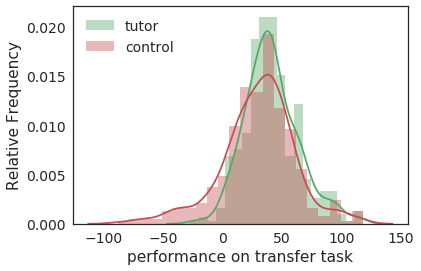

In [73]:
plt.figure()
sns.distplot(posttest[posttest.with_feedback].score,color='g',label='tutor')
sns.distplot(posttest[posttest.with_feedback==False].score,color='r',label='control')
plt.legend(loc='upper left')
plt.xlabel('performance on transfer task')
plt.ylabel('Relative Frequency')

level 0:   0.0% vs. 1.5e+01% (Z=-8.17, p=3.08e-16)
level 1:   2.4% vs. 2.3e+01% (Z=-8.87, p=7.2e-19)
level 2:   0.0% vs.  0.75% (Z=-1.78, p=0.0754)
level 3:   5.2% vs.   3.2% (Z=1.41, p=0.159)
level 4:  0.24% vs.   0.0% (Z=0.976, p=0.329)
level 5: 9.2e+01% vs. 5.8e+01% (Z=11.2, p=2.82e-29)


AttributeError: 'set' object has no attribute 'pid'

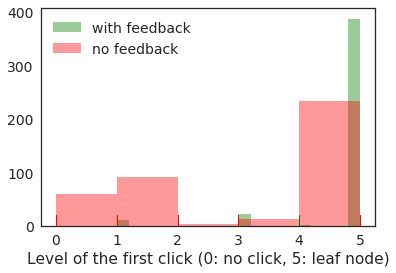

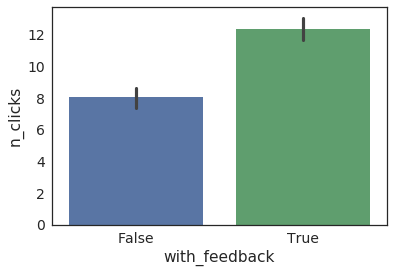

In [74]:
import statsmodels.stats.proportion as proportion

trial_ids = posttest['clicks'].keys()

level_of_first_click = np.array([])
nr_clicks = np.array([])

#3-1-1-2-3 environment
nodes_by_level = dict()
nodes_by_level[0]=[0]
nodes_by_level[1]=[1,12,23]
nodes_by_level[2]=[2,13,24]
nodes_by_level[3]=[3,14,25]
nodes_by_level[4]=[4,8,15,19,26,30]
nodes_by_level[5]=[5,6,7,9,10,11,16,17,18,20,21,22,27,28,29,31,32,33]

for t in trial_ids:
    clicks = posttest['clicks'][t]
    
    nr_clicks = np.append(nr_clicks,[len(clicks)])
    
    if len(clicks)>0:    
        first_click = clicks[0]
        for l in range(len(nodes_by_level)):
            if first_click in nodes_by_level[l]:
                level_of_first_click = np.append(level_of_first_click,[l])
    else:
            level_of_first_click = np.append(level_of_first_click,[0])

posttest['level_of_first_click'] = pd.Series(level_of_first_click)
            
np.mean(level_of_first_click[posttest.with_feedback==True]==3)
np.mean(level_of_first_click[posttest.with_feedback==False]==3)

plt.figure()
sns.distplot(level_of_first_click[posttest.with_feedback==True], color='green', kde=False, rug=True,label='with feedback');
sns.distplot(level_of_first_click[posttest.with_feedback==False], color='red', kde=False, rug=True,label='no feedback');
plt.legend()
plt.xlabel('Level of the first click (0: no click, 5: leaf node)')

click_levels = [0,1,2,3,4,5]
leaf_level = 5;
z = dict()
p = dict()

nr_observations_by_level_FB = np.array(click_levels)
nr_observations_by_level_noFB = np.array(click_levels)

for l in click_levels:
    counts= np.array([ np.sum(level_of_first_click[posttest.with_feedback==True]==l),
             np.sum(level_of_first_click[posttest.with_feedback==False]==l)])
    
    nobs = np.array([ len(level_of_first_click[posttest.with_feedback==True]),
             len(level_of_first_click[posttest.with_feedback==False])])
    
    nr_observations_by_level_FB[l] = counts[0]
    nr_observations_by_level_noFB[l] = counts[1]

    
    z[l],p[l] = proportion.proportions_ztest(counts, nobs)

    print('level {}: {:5.2}% vs. {:5.2}% (Z={:4.3}, p={:4.3})'.format(l,100*counts[0]/nobs[0], 100*counts[1]/nobs[1], z[l],p[l]))

plt.figure()
sns.barplot(x='with_feedback',y='n_clicks',data=posttest)

avg_nr_clicks_FB=posttest[posttest['pid'].isin(feedback_group.pid)].n_clicks.mean()
avg_nr_clicks_noFB=posttest[posttest['pid'].isin(control_group.pid)].n_clicks.mean()

std_nr_clicks_FB=posttest[posttest['pid'].isin(experimental_group.pid)].n_clicks.std()
std_nr_clicks_noFB=posttest[posttest['pid'].isin(control_group.pid)].n_clicks.std()


t,p = stats.ttest_ind(posttest[posttest['pid'].isin(experimental_group)].n_clicks,posttest[posttest['pid'].isin(control_group)].n_clicks)
print("Avg. nr. clicks: {:3.2} +- {:3.2} vs. {:3.2} +- {:3.2} (t({})={:3.2}, p={:5.4})".format(
        avg_nr_clicks_FB,avg_nr_clicks_noFB,std_nr_clicks_FB,std_nr_clicks_noFB,
        N_feedback+N_control-2, t, p))